# Deep Learning Explained

# Module 6 - Introduction to Convolutional Neural Networks


## 1.0 Introduction to convolutional neural networks

This lesson introduces you to a powerful neural network architecture, known as **convolutional neural networks**. Convolutional neural networks operate by **learning a set of filters**  or **convolution kernels**. Using a process, known as **convolution**, these filters extract a **feature map** from the raw data. The feature map is a **lower dimensional** map compared to the raw input features. This map is learned in a supervised machine learning process employing backpropagation. You can think of convolutional neural networks as a powerful and flexible **dimensionality reduction** or **encoding** method. 

Convolutional neural networks are used to build feature maps from any type of data with coherency in one or more dimensions. This includes time series data, and text data as one dimensional cases, and image data as a multi-dimensional case. 

Convolutional neural networks have a fairly long history. The first known commercial application was for automated processing of check images by LeCun et. al. (1998). For unclear reasons, convolutional neural networks were relegated to specialized applications such as hand writing recognition until Krizhevsky et. al. (2012) used them to decisively win an ImageNet object recognition competition. Curiously, other teams had previously used convolutional neural networks to win competitions, but somehow this was not widely recognized. 

In this lesson you will learn:
1. The basics of convolutional neural network architecture.
2. How convolutional neural networks learn the filters to create the feature map. 
3. Feature extraction for creating the feature map. 
4. Visualization of the feature map and the filters.
5. Commonly used convolutional operator designs. 
6. How to use the feature map in supervised learning. 

****
**Note:** The formulation of convolution filters used in deep learning is somewhat idiosyncratic. If you are familiar with the standard approach as applied in say electrical engineering or control engineering you may find the approach used here a bit different. 
****

In [34]:
import numpy as np
import numpy.random as nr
from tensorflow import set_random_seed
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
import keras.utils.np_utils as ku
import keras.models as models
import keras.layers as layers
from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import rmsprop, Adam

%matplotlib inline

### 1.1 Convolution in 1 dimension

To get started, let's work with the simplest case of one dimensional convolution. Convolution is a process of applying a filter of a certain span over one of more dimensions of the data. 

To conceptually understand 1-d convolution examine Figure 1.1 below.. At each time step a value for output series is computed by applying the convolution operator to the input series. The convolution operator is a set of weights $\{ W_1, W_2, W_3 \}$ which are multiplied by the input values. The weighted inputs are then summed to compute the value of the output series. The operator is then moved along the input series (by the stride of 1 in this case). The process proceeds until the end of the series is reached. 

Notice that the output series is shorter than the input series by $\frac{Span + 1}{2}$. In the illustrated example the kernel has a span of 3, making the output series shorter by 2. This reduction in the length of the output is inherent in all convolution operations. 

![](img/ParameterSharing.JPG)
<center>**Figure 1.1. 1-d convolution with operator span of 3**</center> 

Mathematically, we write the convolution operation:

$$s(t) = (x * k)(t) = \sum_{\tau = -\infty}^{\infty} x(t) k(t - \tau)$$
where,   
$s(t)$ is the output of the convolution operation at time $t$,  
$x$ is the series of values,  
$k$ is the convolution kernel,  
$*$ is the convolution operator,  
$\tau$ is the time difference of the convolution operator.  


Summing over the range $\{-\infty, \infty \}$ seems to be a problem. However, in practice the convolutional kernel has a finite span. For an operator with an odd numbered span, we can then rewrite the above equation as:

$$s(t) = (x * k)(t) = \sum_{\tau = {t - a}}^{t + a} x(t) k(t - \tau)$$    

Where, $a = \frac{1}{2}(kernel\_span + 1)$, for an odd length kernel. 

In other words, we only need to take the sum over the span of the convolution operator. Notice that this operator is non-causal, since values from ahead of the time step being operated on are used to compute the output. 

To make this all a bit more concrete, let's try a code example. We will construct a short filter and apply it over a 1-d series. The code in the cell below implements a simple 1-d convolution operation given a set of kernel weights. The core of this operation is a dot product between the subset of values of the series and the kernel weights. The kernel in this case is a type of moving average operator. 

In [35]:
nr.seed(12233)
kernel = np.array([0.25, 0.5, 0.25])

def conv_1d(series, kernel):
    '''Performs simple 1d convolution over the series values
    given the kernel weights. This function only works for 
    kernels with odd span'''
    out =[]
    span = kernel.shape[0]
    half_span = int((span - 1)/2)
    len = series.shape[0]
    for i in range(0, len - span):   
        out.append(np.dot(series[i:i+span], kernel))
    return np.array(out)        
        
series = np.concatenate((nr.normal(size = 40), nr.normal(size = 40) + 2.0))  
result = conv_1d(series, kernel)

To display and examine these results, execute the code in the cell below.  

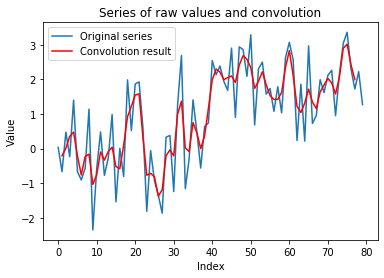

In [36]:
def plot_conv(series, conv, span):
    x = list(range(series.shape[0]))
    offset = int((span-1)/2)
    end = series.shape[0] - offset -1
    plt.plot(x, series, label = 'Original series')
    plt.plot(x[offset:end], conv, color = 'red', label = 'Convolution result')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Series of raw values and convolution')
    
plot_conv(series, result, 3)    

You can see that the convolution result is a smoothed version of the raw input series. 

Let's try another example. In the cell below the convolutional kernel is a first order difference operator. Execute this code and examine the results.

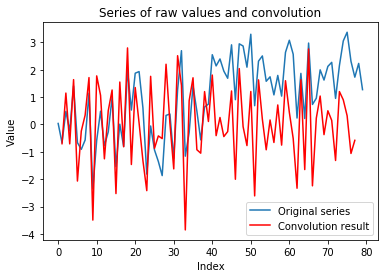

In [37]:
kernel = np.array([-1.0,1.0,0.0])
result = conv_1d(series, kernel)
plot_conv(series, result, 3)  

In this case, the convolutional result shows the different between the two adjacent values of the original series. In financial analysis this difference series is known as the **return series**. 

### 1.2 Applying 2-d convolution

Next, let's look at how we can apply convolution operations in two dimensions. The theory is largely the same as the 1d case.  

Figure 1.2 illustrates a simple example of applying a convolution operator to a 2-d input array. The 2-d input array can be a gray-scale image, for example. 

A 3X3 convolutional operator is illustrated in Figure 1.2. This operator is applied to a small image of dimension of 4X4 pixels. Within the 4X4 image the operator is only applied four times, where the complete operator lies on the image. Convolution where the operator is completely contained within the input sample is sometimes called call **valid convolution**. 

In this case the 4X4 pixel input results in a 2X2 pixel output. You can think of the convolutional operator mapping from the center of the operator input to pixel in the output. Similar to the 1-d case, for a convolution operator with span $s$ in both dimensions the output array will be reduced in each dimension by $\frac{s + 1}{2}$

![](img/2D-Conv.JPG)
<center>**Figure 1.2. Simple 2-d convolution operation**</center>

For a convolution with the identical span $s$ in both dimensions we can write the convolution operations as: 

$$S(i,j) = (I * K)(i,j) = \sum_{m = {i - a}}^{i + a} \sum_{n = j - a}^{j + a} I(i, j) K(i-m, j-n)$$

Notice that $S$, $I$ and $K$ are all tensors. Given this fact, the above formula is easily extended to higher dimensional problems. 

The convoluational kernel $K$ and the image $I$ are commutative so there is an alternative representation by applying an operation known as **kernel flipping**. Flipped kernel convolution can be represented as follows:

$$s(i,j) = (I * K)(i,j) = \sum_{m = {i - a}}^{i + a} \sum_{n = j - a}^{j + a} I(i-m, j-n) K(i, j)$$


### 1.3 Convolution in higher dimensions

In deep convolutional neural networks the input typically have several **input channels** with the convolution operation resulting in multiple **output channels**. 

So far, we have only looked at single channel convolution. Here are some examples of input tensors with different numbers of input channels:
- A gray-scale image has a single input channel of pixels. 
- A color image typically has 3 input channels, {Red, Green, Blue}.
- A color movie has a large number of input channels. For $n$ images in the video there are $3 * n$ images counting the Red, Green, Blue channels for each image.  

The purpose of the a convolutional neural network is to create a feature map. To create the most general feature map convoluation operators need not be restricted to a single input channel. 

Further, the feature map can have many channels, resulting in multiple output channels. Each channel is a set of features extracted from the input tensor. This concept is illustrated in Figure 1.3 below. In this figure a set of convolution operators transform the input tensors to multiple channels of the feature map. Each convolution operator maps to a specific output channel in the feature map. 

![](img/MultiChannel.JPG)
<center>**Figure 1.3. Example of multichannel convolution**</center>

Let's investigate the case of a 3-d input tensor $V$, a 3-d output tensor $Z$ and 4-d convolution tensor $K$. In this case the convolution equation becomes:

$$Z_{i,j,k} = (V * Z)(i,j,k,l) = \sum_{l} \sum_{m = -a}^{a}
\sum_{n = -a}^{a}
V_{i,j,l} \cdot K_{i-m,j-n,k,l}$$
where,  
$i,j$ are the spatial dimenstions,  
$k$ is the index of the output channel,  
$l$ is the index of the input channel,  
$K_{i,j,k,l}$ is the kernel connecting the $l$th channel of the input to the $k$th channel of the output for pixel offsets $i$ and $j$    
$V_{i,j,l}$ is the $i,j$ input pixel offsets from channel $l$ of the input,  
$a = \frac{1}{2}(kernel\_span + 1)$, for an odd length kernel.  

Notice that the summation in the equation above is over input channels $l$ as well as the spatial dimensions $m,n$ of the convolutional operator. This operation is applied for each spatial pixel coordinate $i,j$. This generalization allows the convolutional kernel to operate over multiple input channels. This is property is highly desirable since features should be extracted from the entire input tensor. 

The entire forgoing operation is performed for each output channel $k$. Therefore, you can think of the $k$th dimension of the 4-d kernel tensor as indexing multiple 3-d convolution kernels. 

### 1.4 Parameter sharing and sparse interactions

**Parameter sharing** and **sparse interactions** are two powerful aspects of convolutional neural networks. To understand what these terms mean and why they are important, consider the fully connected neural network in Figure 1.4 below.  
![](img/FullyConnected.JPG)
<center>**Figure 1.4. A fully connected network**</center>

The fully connected neural network has a relatively large number of weights, $5^2 = 25$ in this case. Compare this network to the convolutional layer depicted in Figure 1.1. The convolutional network only has 3 weights which are **shared** across the entire layer. Parameter sharing is also referred to as **tied weights**. This is an example of a **sparse interaction**.

The shared nature of the parameters in convolutional neural networks is a significant reduction in complexity. Statistically, such a sparse model is said to **share statistical strength**. This statistical strength results in model weights with less uncertainty and a model less likely to be over-fit.  

The computational efficiency of convolutional neural networks is not just in training. Convolutional neural networks are also efficient for making predictions in production.

### 1.5 Detection

So far we have only looked at linear convolutional operators. However, to improve **detection** of features for the map, nonlinear activation is required.  Conceptually, the nonlinear detector creates a stronger response from detected features. As with other neural networks, nonlinear activation is required if we want our network to learn filters which detect features that are not just linear responses to the original features. Typically the rectilinear activation function is used.    

To see how such a feature detector works, let's try a two channel example. In this case, we will use a square wave function that is first positive and then negative as our feature. Aficionados of obscure functions will notice this is a Harr basis function (Harr, 1909). 

In order to detect this feature we will use two convolution kernels, a first order difference operator and its inverse.  

To display the feature and the output of the first convolution channel execute the code in the cell below and examine the result. 

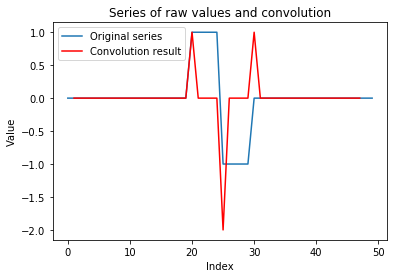

In [38]:
nr.seed(12233)
series1 = np.concatenate((np.zeros((20,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((20,))))
kernel1 = np.array([-1.0, 1.0, 0.0])
result1 = conv_1d(series1, kernel1)
plot_conv(series1, result1, 3)  

As expected the first order difference operator acts as an edge detector. The output for the first channel are the positive and negative edges of the feature. 

Now run the code in the cell below to compute and display the result for the inverse difference operator. 

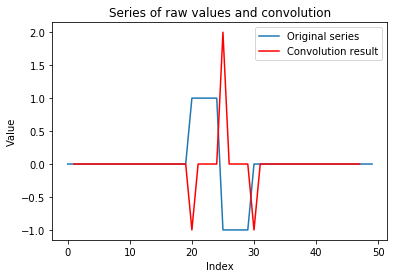

In [39]:
kernel2 = np.array([1.0, -1.0, 0.0])
result2 = conv_1d(series1, kernel2)
plot_conv(series1, result2, 3)  

Again, the inverse difference operator detects edges, but with the opposite sign. 

Now, it is time to apply the nonlinear activation or detection to these two channels. The code in the cell below applies a rectilinear activation to the convolution results and displays the result. Execute this code and examine the results. 

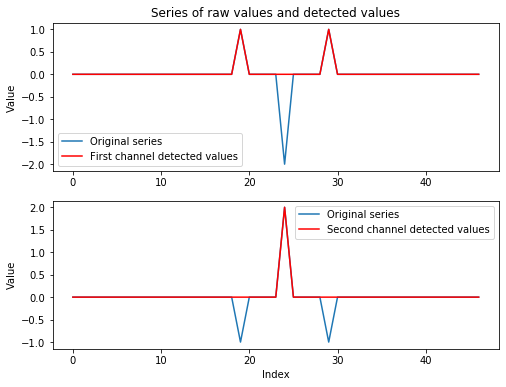

In [40]:
def relu(series):
    return np.array([x if x > 0.0 else 0.0 for x in series])

def plot_detect(series, series2, detect1, detect2):
    x = list(range(series.shape[0]))
    fig = plt.figure(figsize=(8,6))
    ## First channel
    plt.subplot(2, 1, 1)
    plt.plot(x, series, label = 'Original series')
    plt.plot(x, detect1, color = 'red', label = 'First channel detected values')
    plt.legend()
    plt.ylabel('Value')
    plt.title('Series of raw values and detected values')
    ## Second channel
    plt.subplot(2, 1, 2)
    plt.plot(x, series2, label = 'Original series')
    plt.plot(x, detect2, color = 'red', label = 'Second channel detected values')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    
detect1 = relu(result1)
detect2 = relu(result2)
plot_detect(result1, result2, detect1, detect2)

Notice that the two channels are quite different responses to the same feature. This simple result demonstrates the reason we construct models that use multi-channel convolution when building feature maps. 

### 1.6 Pooling and invariance

To further reduce dimensionality and to make the feature map robust to small shifts in the input, **pooling** is applied following the nonlinear detection stage. Pooling involves applying an aggregation function to patches of the output from the nonlinear detector of a convolution layer. 

Researchers have tried a number of pooling schemes. In practice **max pooling** (Zhou and Chellappa, 1988) has proved to be both robust and versatile. In max pooling the output value is just the maximum of the input values in each patch. 

Unlike convolutional layers, there are no parameters to learn in pooling layers. 

Max pooling has the nice property of being robust to small shifts in the input values. For example, Figure 1.5 shows the response of max pooling to a right sift of a single pixel for an operator with a span of 3. Notice that the response itself is simply shifted one pixel to the right as well. The pattern of maximum values in the feature map (the output) remains the same. 

![](img/ShiftOne.JPG)
<center>**Figure 1.5.   
    Example of max pooling responses to one pixel shift right**</center>
    
Let's try a simple computational example of max pooling, picking up from the previous feature detection example. The code in the cell below applies max pooling with an operator span of 2, stride of 2 and displays the result for each of the output channels from the detector. The concept of stride is explained below. Execute the code and examine the result. 

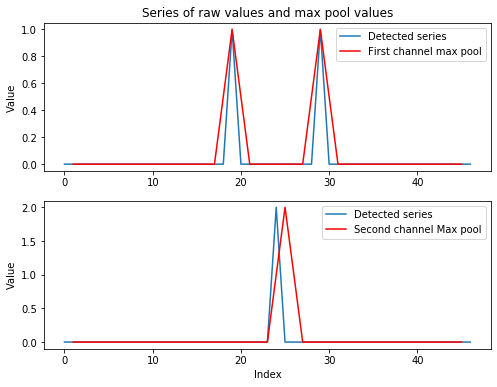

In [41]:
def max_pool_2(series):
    '''Performs simple 1d max pooling with
    an operator span of 2 and stride 2'''
    out =[]
    len = series.shape[0]
    for i in range(0, len - 1, 2):  
        out.append(np.max(series[i:i+2]))
    return np.array(out)    

def plot_pool(series1, series2, pool1, pool2):
    x = list(range(series1.shape[0]))
    end = series1.shape[0]
    fig = plt.figure(figsize=(8,6))
    ## First channel
    plt.subplot(2, 1, 1)
    plt.plot(x, series1, label = 'Detected series')
    plt.plot(x[1:end:2], pool1, color = 'red', label = 'First channel max pool')
    plt.legend()
    plt.ylabel('Value')
    plt.title('Series of raw values and max pool values')
    ## Second channel
    plt.subplot(2, 1, 2)
    plt.plot(x, series2, label = 'Detected series')
    plt.plot(x[1:end:2], pool2, color = 'red', label = 'Second channel Max pool')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
           
pool1 = max_pool_2(detect1)
pool2 = max_pool_2(detect2)
plot_pool(detect1, detect2, pool1, pool2)   

In this case, the max pooled result is a decimated (reduced number of output values) of the input. 

Let's summarize what we have done here. We have gone from a raw input series to a feature map with two channels. One channel shows positive transitions, the other channel shows negative transitions. Other convolutional kernels can be used to create more channels sensitive to other types of features. 

Next, let's look at an example of shifting a feature. In this case, the feature is shifted by 10 to the left. Execute the code below to compute and display the output of the two channels of the convolutional layers following  rectilinear detection. 

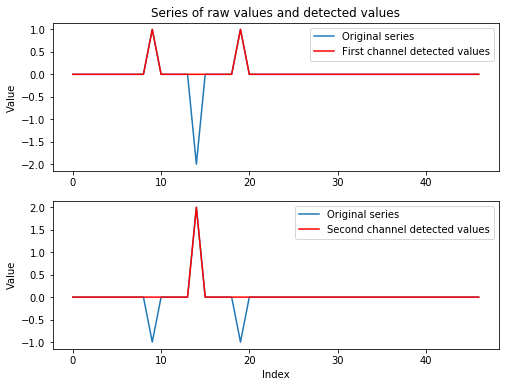

In [42]:
nr.seed(12233)
series2 = np.concatenate((np.zeros((10,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((30,))))
result21 = conv_1d(series2, kernel1)
detect21 = relu(result21)
result22 = conv_1d(series2, kernel2)
detect22 = relu(result22)
plot_detect(result21, result22, detect21, detect22) 

This feature has the same map as before, just shifted by 10. 

Execute the code in the cell below to apply max pooling to the two convolutional channels. 

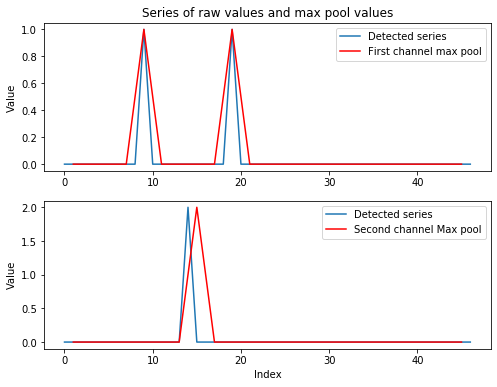

In [43]:
pool21 = max_pool_2(detect21)
pool22 = max_pool_2(detect22)
plot_pool(detect21, detect22, pool21, pool22)

As before, the output of the max pooling operator is just a left shifted version of the map of the feature for both channels. This is a critical point. Our feature map will show a shifted version of the response regardless of where the feature lies in the input space. 

### 1.7 Stride and tiling

Up until now, we have only moved the convolution operator one pixel at a time. There is no restriction that requires this type of step, however. In fact, a convolutional operator or pooling opertor can be moved by several pixels in any direction. This step size is known as the **stride** of the operator. 

Operators with stride greater than one **decimate** the number of pixels in the output. This can be useful when resizing images of different dimensions so they have constant input dimensions for a neural network. 

Using an operator with $stride = span$ is a special case known as **tiling**. Tiled operators are layed out without any overlap. Figure 1.6 shows an example of tiling. In this case, an input of dimensions $6X6$ is tiled by operators with dimension $3X3$ with stride of 3. Only 4 tiles fit on the input in this case, resulting in a $4X4$ output array. Tiling is often used with max pooling operators. 

![](img/Tiled.JPG)
<center>**Figure 1.6. Example of a tiled convolution operator**</center>

## 2.0 Convolutional neural networks with Keras

With the foregoing theory and simple examples in mind, let's try constructing and testing a convolutional neural network using Keras. In this case, we will test classification of the MNIST dataset. The neural network will have the following layers:
1. An input layer for the 28X28 images.
2. A multi-layer convolutional neural network to create a feature map.
3. A fully-connected hidden layer to perform the classification.
4. A output layer to indicate which digit is most likely. 

### 2.1 Preparing the dataset

The preparation of this dataset is follows nearly identical steps to the process followed in an earlier lesson. In summary, three preparation steps are performed:
1. Load the training and test image data and labels.
2. Reshape the image tensors so the neural network views them as a 4-d tensor. For the training images the tensor has a shape of (60000,28,28,1) corresponding to 60000 images of dimension 28X28 with a single channel (these are gray-scale images). At the same time the pixel values are converted to `float` type in the range $$\{ 0,1 \}.
3. The labels are recoded as dummy variables.

In [44]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [45]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float')/255
print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28, 1)
float64


In [46]:
print(test_images.shape, test_labels.shape)
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float')/255
print(test_images.shape)

(10000, 28, 28) (10000,)
(10000, 28, 28, 1)


In [47]:
train_labels = ku.to_categorical(train_labels)
print(train_labels[5:,])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [48]:
test_labels = ku.to_categorical(test_labels)

### 2.2 Defining the model. 

**Exercise 1:**  It is now time to define the model. 

As a first step, the callbacks required to implement early stopping regularization are defined. 

In [49]:
## Set up and call-backs for early stopping
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 1 # Stop after one step with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True # Only save model if it is the best
        )
]


You will define the Keras neural network model by creatng the required code in the cell below. **Make sure you name your model nn** or subsequent parts of this notebook will not work correctly. 

This model using both convolutional layers and max pooling layers. You can find [documentation on the convolutional layers in the Keras documentation](https://keras.io/layers/convolutional/). You can find [documentaton on pooling layers in the Keras documentation](https://keras.io/layers/pooling/).

The architecture of this model is:
1. A 3X3 convolutional layer with 32 output channels. Recall that this operation creates a feature map with 32 channels from the single gray-scale input channel. You will use the `layers.Conv2D` function with ReLU activation and the required input shape. 
2. A 2X2 max pooling layer, using the `layers.MaxPooling2D` function.
3. A 3X3 convolution layer with 64 output channels, and ReLU activation. The 32 input channels are mapped to a 64 channel output feature map. 
4. Another 2X2 max pooling layer. 
5. A final 3X3 convolution layer with 64 output channels, and ReLU activiation. 
6. The 64 channel feature map is flattened to a vector, using the `layers.Flatten()` function.
7. A dense (fully-connected) hidden layer with 64 units and ReLU activation is the first classifier layer. Use 0.01 as the l2 regularization parameter. This layer operates on the flattened feature map. 
8. A 0.5 probability dropout layer is used to improve regularization of the model. 
9. The dense output layer has 10 units with softmax activation to indicate the classification of the digits.
10. A summary of the model is printed with the `summary` function. 

Execute this code and examine the summary of the model. 

In [65]:
## Define the Squential model as usual. 
nns = models.Sequential()

## Add some convolutional layers to extract features 
## from the images with padding added to the convolution layers.
nns.add(layers.Conv2D(32, (3, 3),activation = 'relu', input_shape = (28, 28, 1)))
nns.add(layers.MaxPooling2D((2, 2)))
nns.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
nns.add(layers.MaxPooling2D((2, 2)))
nns.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

## Now flatten the output of the convolutional layers so 
## a fully connected network can be applied.
nns.add(layers.Flatten())

## Finally, fully connected layers to classify the digits 
## Using the features extracted by the convolutional layers.
nns.add(layers.Dense(64, activation = 'relu',
                        kernel_regularizer=regularizers.l2(0.01)))
nns.add(Dropout(0.5))
nns.add(layers.Dense(10, activation = 'softmax'))

nns.summary()








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_18 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                36928     
__________

There is quite a bit of interesting information in the summary of this model. Examine this output to understand the structure of the model better. 



### 2.3 Train and test the model

**Exercise 2:**  Now, it is time to compile and fit the model. In the cell below create and execute the code to compile and fit the model you have defined.

1. For the compile step use `RMSprop` as the optimizer, `categorical_crossentropy` as the loss function and `accuacty` as the metric. 
2. Set a `numpy.random` seed of 2356. 
3. Use the `set_random_seed` function to set a seed of 2333 for the Tensorflow backend.
4. Set a Tensorflow random seed with the 'set_random_seed' function of 2333.
5. For the model fitting step use 40 `epochs` and a `batch_size` of 128.

In [69]:
## Compile the model
nns.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Now fit the model
nr.seed(2356)
set_random_seed(2333)

history_s = nns.fit(train_images, 
                    train_labels, 
                    epochs = 40, 
                    batch_size = 128,
                    validation_data = (test_images, test_labels),
                    callbacks = callbacks_list,  # Call backs argument here
                    verbose = 1
                   )




Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 32s 533us/step - loss: 0.0610 - acc: 0.9885 - val_loss: 0.0572 - val_acc: 0.9890
Epoch 2/40
60000/60000 [==============================] - 31s 517us/step - loss: 0.0595 - acc: 0.9890 - val_loss: 0.0724 - val_acc: 0.9881


Compare these results to those obtained using only fully connected layers in labs you completed previously.  

Run the code in the cell below to plot the loss history vs. epoch.

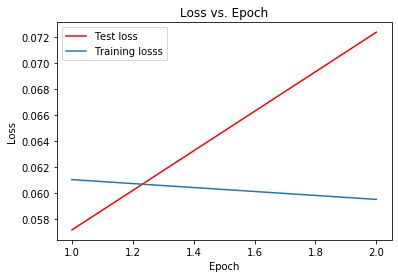

In [71]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Training losss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
history = history_s
plot_loss(history)    

Compare these results to those obtained using only fully connected layers in labs you completed previously.  

Execute the code in the cell below to display and examine the curve of accuracy with epoch. 

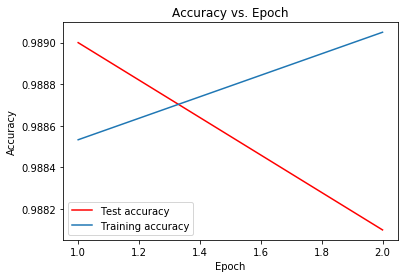

In [72]:
def plot_accuracy(history):
    train_acc = history.history['acc']
    test_acc = history.history['val_acc']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
    plt.plot(x, train_acc, label = 'Training accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(history)   

Compare these results to those obtained using only fully connected layers in labs you completed previously.  


## 3.0 What features does the convolutional neural network learn?

You might well ask, what is in the various layers of the feature map? It turns out, we can actually visualize the output from each layer of the convolutional neural network. This can be done for both convolutional and max pooling layers.

As a first step we must pick an image to use as the test case. For this example, we are  arbitrarily using the 13th image in the training tensor. Execute the code in the cell below to visualize this image. 

(28, 28, 1)


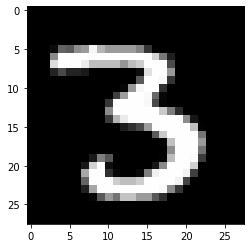

In [73]:
img = train_images[12,:,:,:]
print(img.shape)
plt.imshow(img.reshape((28,28)), cmap = 'gray')

Our sample image turns out to be a number 3. 

The code in the cell below does the following:
1. Extracts the layers from the model object into a list. 
2. Creates an activation model for the set of layers using the input of the original model object and the list of layer outputs. 
3. Computes the activations for each layer by applying the predict method to the activation model. 

Execute this code to create a list of activations for the convolutional neural network. 

In [75]:
nn = nns



layer_outputs = [layer.output for layer in nn.layers[:7]]
activation_model = models.Model(inputs = nn.input, outputs = layer_outputs)
activations = activation_model.predict(img.reshape(1,28,28,1))

The code in the cell below does the following:
1. Iterates through the activations of the first 5 model layers.
2. Iterates over the activation channel in the layer displaying the image. There is one image for each channel in the feature map. 

Execute this code and examine the result.

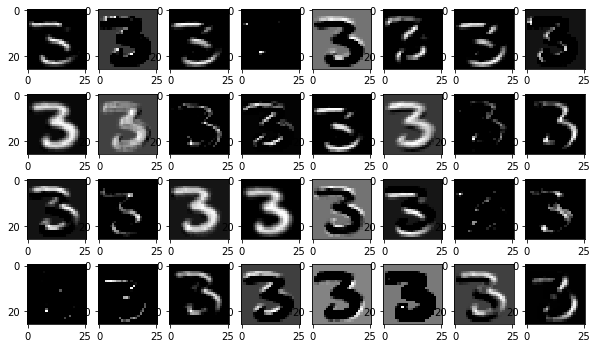

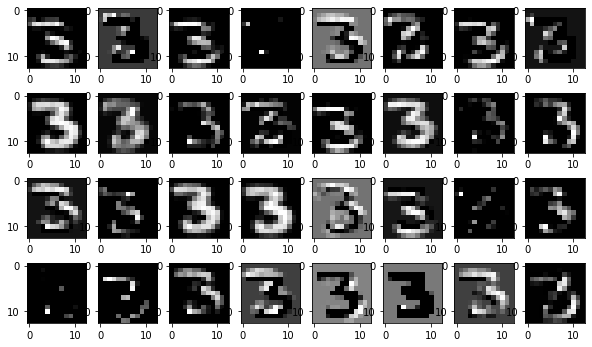

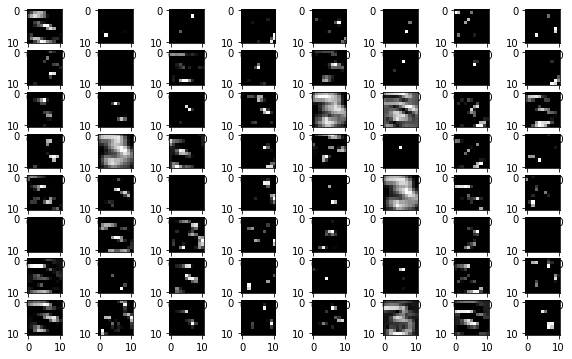

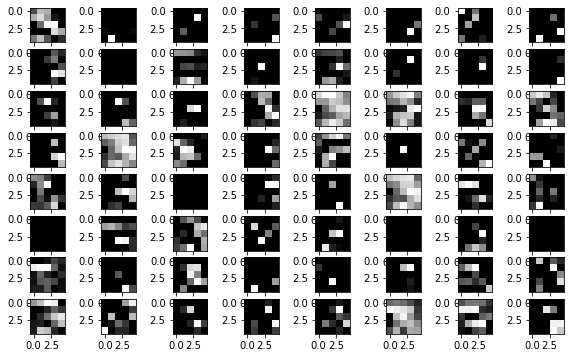

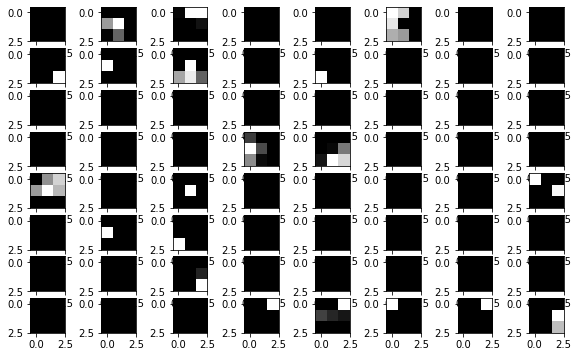

In [76]:
for j in range(5):
    fig_shape = activations[j].shape
    s = fig_shape[3]/32
    fig = plt.figure(figsize=(10,6))
    for i in range(fig_shape[3]):
        ax = fig.add_subplot(s*4,8,(i+1))
        plt.imshow(activations[j].reshape((fig_shape[1],fig_shape[2],fig_shape[3]))[:,:,i], cmap='gray')

Examine the above sets of tenosrs. The activations of the shallow feature maps look fairly similar to the test image. However, as go deeper two things happen:
1. The initial single channel 28X28X1 input image tensor becomes a 32X26X26X1 32 channel feature map after the first convolution.
2. The max pool layers decimate the outputs of the convolution layers. This results in a blocky appearance. 
3. The second convolutional layer transforms the 32 channel 32X13X13X1 feature map tensor from the max pool layer to a 64 channel 64X11X11X1 feature map. 
4. The activations become more abstract with depth. You can recognize aspects of the original image in upper layers. It is no longer possible to tell what the original image might be in the deepest layers. 
5. The activations become sparse. The deepest level of the map is only 3X3 for each of the 64 channels in the feature map. This feature map represents aspects of the original image as single pixels or features. 

In summary, as you go to deeper feature maps the result is less human understandable, but more abstracted and amenable to machine learning. 

## 4.0 Padding convolution

As you have observed, each convolution layer in a neural network reduces the spatial dimensions by $\frac{span+1}{2}$ for odd span kernels. The coverage of the convolution opertor can be expanded by **zero padding** in the spatial dimenstion. With the zero padding added, the convolution operator covers the entire spatial dimension of the input tensor. This type of convolution is sometime referred to as **same convolution**, since the output tensor has the same spatial dimensions. 

In some situations, adding zero padding produces a better feature map. Zero padding allows each pixel to be visited the same number of times by the convolution operator. Without padding pixels at the edge, are not full represented in the feature map. More importantly, the larger feature map will have bigger model capacity. 

2-d convolution with zero padding is illustrated in Figure 4.1 below. The original input 2-d input tensor is shown in gray. The span of the kernel is 3X3 so one additional column of zeros is added to each sided along with a row of zeros top and bottom. As illustrated, the kernel can operate on the edge pixels. The result is an output tensor with the same spatial dimension as the input. 

![](img/Padding.JPG)
<center>**Figure 4.1. 2-d convolution with zero padding**</center>

With Keras, adding zero padding to convolutional layeres is easy. The `padding = same` argument adds zero padding. The default is `padding = valid` which adds no padding. 

The code in the cell below specifies a similar model to the one already investigated. The only difference is that padding has been added to the `Conv2D` methods. Execute this code and examine the summary. 

In [77]:
## Define the Squential model as usual. 
nns = models.Sequential()

## Add some convolutional layers to extract features 
## from the images with padding added to the convolution layers.
nns.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
nns.add(layers.MaxPooling2D((2, 2)))
nns.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
nns.add(layers.MaxPooling2D((2, 2)))
nns.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))

## Now flatten the output of the convolutional layers so 
## a fully connected network can be applied.
nns.add(layers.Flatten())

## Finally, fully connected layers to classify the digits 
## Using the features extracted by the convolutional layers.
nns.add(layers.Dense(64, activation = 'relu',
                        kernel_regularizer=regularizers.l2(0.01)))
nns.add(Dropout(0.5))
nns.add(layers.Dense(10, activation = 'softmax'))

nns.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_19 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                200768    
__________

Examine the summary. There are two differences with the un-padded case. 
1. The final feature map is 7X7X64, rather than 3X3X64 without padding. This feature map has 49 pixels per channel, compared to 9 pixels per channel previously. This larger feature map can accommodate a good deal more model capacity. 
2. The number of parameters for the convolutional layers has not changed from the first model. This is a result of the parameter sharing with the operator span remaining the same. 
3. The number of parameters for the fully-connected hidden layer has increased significantly. This is a result of the flattened feature map now having 3,136 pixels. 

Next execute the code in the cell below to compile and fit the model.

In [78]:
## Compile the model
nr.seed(2323)
set_random_seed(4466)
nns.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
    
## Now fit the model
nr.seed(88776)
set_random_seed(5666)
history_s = nns.fit(train_images, train_labels, 
                  epochs = 40, batch_size = 128,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 55s 913us/step - loss: 0.4981 - acc: 0.9017 - val_loss: 0.1525 - val_acc: 0.9793
Epoch 2/40
60000/60000 [==============================] - 54s 893us/step - loss: 0.1913 - acc: 0.9655 - val_loss: 0.1242 - val_acc: 0.9793
Epoch 3/40
60000/60000 [==============================] - 52s 870us/step - loss: 0.1481 - acc: 0.9740 - val_loss: 0.1014 - val_acc: 0.9829
Epoch 4/40
60000/60000 [==============================] - 53s 887us/step - loss: 0.1257 - acc: 0.9778 - val_loss: 0.0828 - val_acc: 0.9874
Epoch 5/40
60000/60000 [==============================] - 55s 910us/step - loss: 0.1115 - acc: 0.9800 - val_loss: 0.0733 - val_acc: 0.9897
Epoch 6/40
60000/60000 [==============================] - 53s 877us/step - loss: 0.1015 - acc: 0.9817 - val_loss: 0.0657 - val_acc: 0.9914
Epoch 7/40
60000/60000 [==============================] - 56s 931us/step - loss: 0.0941 - acc: 0.9831 - val_loss: 0.

## This model reaches a test accuracy approximately the same as the previous model at the second to last epoch. Evidently, the added model capacity was not needed in this case. 

Next, execute the code in the cell below to plot the loss vs. epoch.

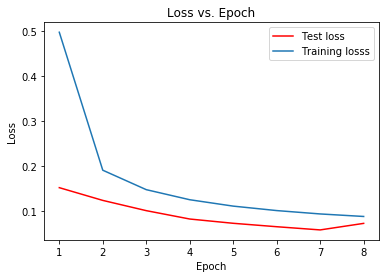

In [79]:
plot_loss(history_s)    

This curve does not look substantially different from the first model. But, notice that the convergence is slower. Perhaps a wider fully connected layer is required? 

As a last step, execute the code in the cell below to plot the accuracy of the model vs. epoch. 

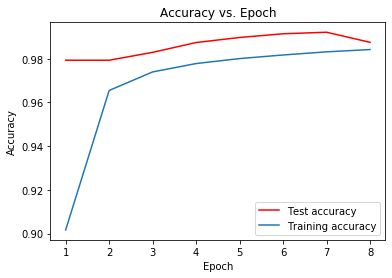

In [80]:
plot_accuracy(history_s) 

Again, the result does not look substantially different from the first model, except for the slower convergence. 

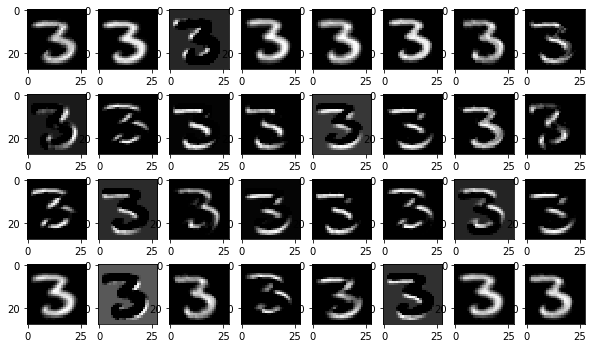

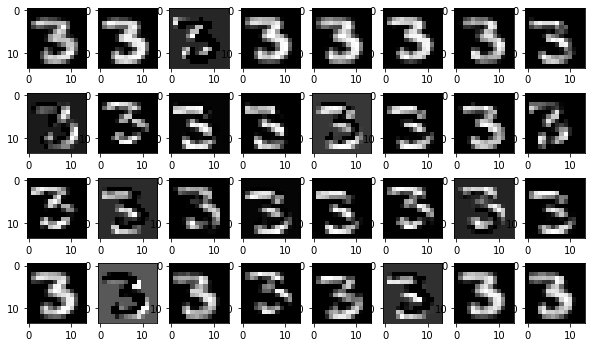

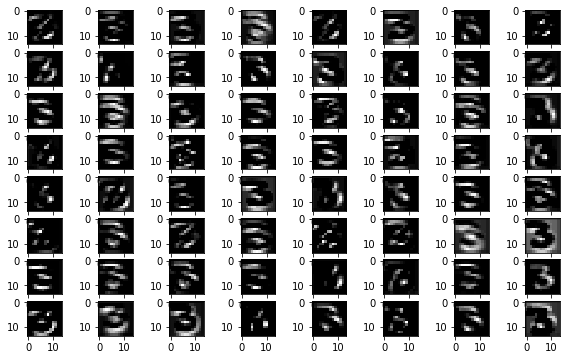

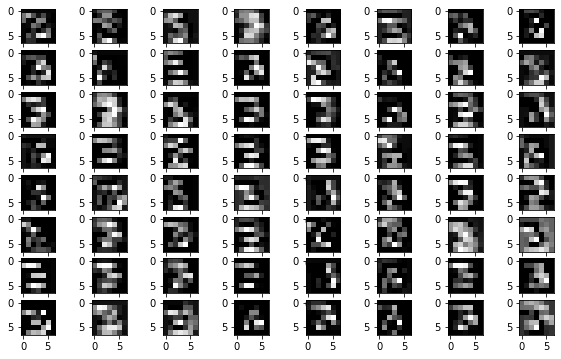

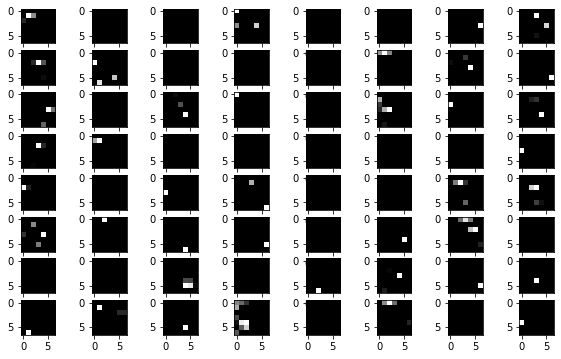

In [81]:
layer_outputs = [layer.output for layer in nns.layers[:7]]
activation_model = models.Model(inputs = nns.input, outputs = layer_outputs)
activations = activation_model.predict(img.reshape(1,28,28,1))



for j in range(5):
    fig_shape = activations[j].shape
    s = fig_shape[3]/32
    fig = plt.figure(figsize=(10,6))
    for i in range(fig_shape[3]):
        ax = fig.add_subplot(s*4,8,(i+1))
        plt.imshow(activations[j].reshape((fig_shape[1],fig_shape[2],fig_shape[3]))[:,:,i], cmap='gray')